In [2]:
from utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model
import torch
from ultralytics import YOLO
from PIL import Image
device = 'cuda'

som_model = get_yolo_model(model_path='weights/icon_detect/best.pt')
som_model.to(device)
print('model to {}'.format(device))

model to cuda


In [3]:
# two choices for caption model: fine-tuned blip2 or florence2

caption_model_processor = get_caption_model_processor(model_name="blip2", model_name_or_path="weights/icon_caption_blip2", device=device)
#caption_model_processor = get_caption_model_processor(model_name="florence2", model_name_or_path="weights/icon_caption_florence", device=device)



Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


In [4]:
som_model.device, type(som_model) 

(device(type='cuda', index=0), ultralytics.models.yolo.model.YOLO)

In [5]:

import json
import svgwrite

cnt = 0
image_path = 'imgs/bio.jpeg'
# image_path = 'imgs/windows_home.png'
#image_path = 'imgs/windows_multitab.png'

BOX_TRESHOLD = 0.03

image = Image.open(image_path)
image_rgb = image.convert('RGB')
print(image.size)
box_overlay_ratio = image.size[0] / 3200
draw_bbox_config = {
    'text_scale': 0.8 * box_overlay_ratio,
    'text_thickness': max(int(2 * box_overlay_ratio), 1),
    'text_padding': max(int(3 * box_overlay_ratio), 1),
    'thickness': max(int(3 * box_overlay_ratio), 1),
}

ocr_bbox_rslt, is_goal_filtered = check_ocr_box(image_path, display_img = False, output_bb_format='xyxy', goal_filtering=None, easyocr_args={'paragraph': False, 'text_threshold':0.9}, use_paddleocr=True)
text, ocr_bbox = ocr_bbox_rslt


dino_labled_img, label_coordinates, parsed_content_list = get_som_labeled_img(image_path, som_model, BOX_TRESHOLD = BOX_TRESHOLD, output_coord_in_ratio=False, ocr_bbox=ocr_bbox,draw_bbox_config=draw_bbox_config, caption_model_processor=caption_model_processor, ocr_text=text,use_local_semantics=True, iou_threshold=0.1, imgsz=640)


property_value_array = list(map(lambda x: [x[0], x[1]], label_coordinates.items()))

parsed : list[str, list[int]] = []
for coordinate in property_value_array:
    index, coord = coordinate

    parsed.append([parsed_content_list[int(index)], coord.tolist()])
    pass





(1135, 2272)

image 1/1 /home/mac/boltStation/OmniParser/imgs/bio.jpeg: 640x320 93 0s, 26.8ms
Speed: 1.1ms preprocess, 26.8ms inference, 47.6ms postprocess per image at shape (1, 3, 640, 320)


Expanding inputs for image tokens in BLIP-2 should be done in processing. Please follow instruction here (https://gist.github.com/zucchini-nlp/e9f20b054fa322f84ac9311d9ab67042) to update your BLIP-2 model. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Expanding inputs for image tokens in BLIP-2 should be done in processing. Please follow instruction here (https://gist.github.com/zucchini-nlp/e9f20b054fa322f84ac9311d9ab67042) to update your BLIP-2 model. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.


In [6]:
result = {
    'image_size' : image.size,
    'coordinates': parsed
}

json_data = json.dumps(result)

print(json_data)

{"image_size": [1135, 2272], "coordinates": [["Text Box ID 0: B", [1090.0, 0.0, 40.0, 24.0]], ["Text Box ID 1: lonogramme: Kaliemie (k)", [158.0, 72.99999237060547, 445.0, 48.0]], ["Text Box ID 2: 3.76", [976.9999389648438, 69.0, 75.00006103515625, 47.0]], ["Text Box ID 3: Ionogramme: Natremie (Na)", [155.99996948242188, 123.0, 487.0000305175781, 50.0]], ["Text Box ID 4: 139.4", [979.0, 121.0, 95.0, 45.0]], ["Text Box ID 5: Bilan renal", [156.0, 237.0, 220.0, 49.0]], ["Text Box ID 6: Uree sanguine", [159.0, 281.0, 247.0, 55.0]], ["Text Box ID 7: 0.32", [984.0, 279.0, 75.0, 45.0]], ["Text Box ID 8: Creatine sanguine", [160.99998474121094, 336.0, 312.0, 47.0]], ["Text Box ID 9: 7.3", [984.0, 334.0, 64.0, 42.0]], ["Text Box ID 10: H", [1102.0, 488.0, 32.0, 47.0]], ["Text Box ID 11: 21.3", [987.0, 577.9999389648438, 83.0, 41.0]], ["Text Box ID 12: TP (inr) taux de prothrombine", [158.00003051757812, 590.0000610351562, 521.0, 37.0]], ["Text Box ID 13: 34.3", [993.0, 627.0, 78.0, 45.0]], ["T

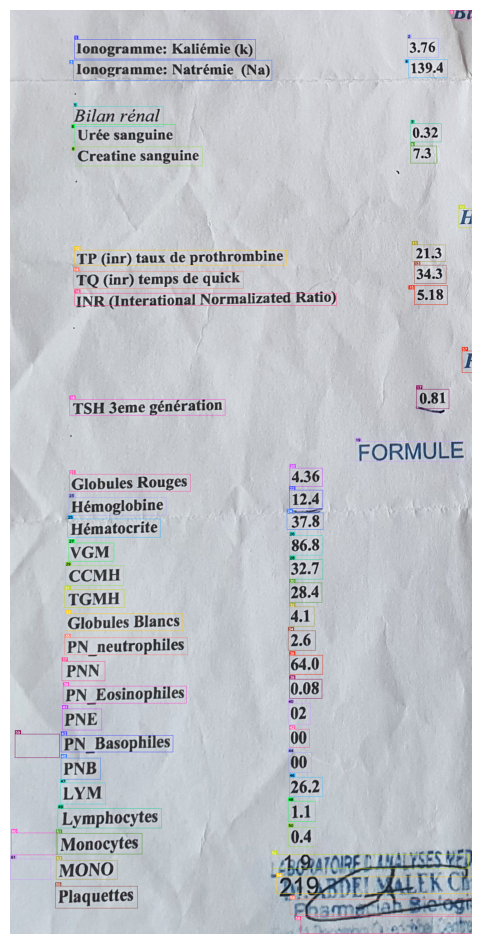

In [7]:
# plot dino_labled_img it is in base64
import base64
import matplotlib.pyplot as plt
import io
plt.figure(figsize=(12,12))

image = Image.open(io.BytesIO(base64.b64decode(dino_labled_img)))
plt.axis('off')

plt.imshow(image)

plt.savefig('output_plot.png', format='png')


In [10]:
from transformers import AutoModelForTokenClassification, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("./weights/icon_detect/best.pt")
model = AutoModelForTokenClassification.from_pretrained("./weights/icon_detect/best.pt")

OSError: Incorrect path_or_model_id: './weights/icon_detect/best.pt'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

In [ ]:
label_coordinates

{'0': array([       1090,           0,          40,          24], dtype=float32),
 '1': array([        158,          73,         445,          48], dtype=float32),
 '2': array([        977,          69,          75,          47], dtype=float32),
 '3': array([        156,         123,         487,          50], dtype=float32),
 '4': array([        979,         121,          95,          45], dtype=float32),
 '5': array([        156,         237,         220,          49], dtype=float32),
 '6': array([        159,         281,         247,          55], dtype=float32),
 '7': array([        984,         279,          75,          45], dtype=float32),
 '8': array([        161,         336,         312,          47], dtype=float32),
 '9': array([        984,         334,          64,          42], dtype=float32),
 '10': array([       1102,         488,          32,          47], dtype=float32),
 '11': array([        987,         578,          83,          41], dtype=float32),
 '12': array([

In [ ]:
torch.cuda.empty_cache()

# del som_model